# Анализ оттока клиентов банка

Менеджменту «МетанПромБанка» необходимо узнать какие клиенты склонны прекращать пользоваться услугами банка, чтобы в дальнейшем попытаться их "удержать" в банке.

**Цель исследования:** изучить влияние признаков на вероятность оттока клиентов.

Данные представлены датасетом `bank_scrooge.csv` со следующими полями:
* `USERID` — идентификатор пользователя,
* `score` — баллы кредитного скоринга,
* `city` — город,
* `gender` — пол,
* `age` — возраст,
* `equity` — количество баллов собственности
* `balance` — баланс на счёте,
* `products` — количество продуктов, которыми пользуется клиент,
* `credit_card` — есть ли кредитная карта,
* `last_activity` — активный клиент,
* `EST_SALARY` — оценочный доход клиента,
* `сhurn` — признак оттока.

План исследования:

1. Импорт библиотек, загрузка данных и изучение основной информации
2. Предобработка данных:
    - Приведение названий полей датафрейма к общему формату
    - Изменение типов данных
    - Обработка пропусков
    - Обработка дубликатов
    - Добавление новых столбцов
3. Исследовательский анализ данных (EDA):
    - Анализ непрерывных количественных признаков
    - Анализ дискретных и категориальных признаков
    - Создание портретов клиентов в разрезе оттока
    - Корреляционный анализ признака "отток" с другими признаками
4. Проверка статистических гипотез:
    - Гипотеза о равенстве средних доходов оставшихся и ушедших клиентов
    - Гипотеза о равенстве средних баллов кредитного скоринга у оставшихся и ушедших клиентов
    - Гипотеза о равенстве среднего возраста для оставшихся и ушедших клиентов
    - Гипотеза о равенстве баланса на счете для оставшихся и ушедших клиентов
5. Промежуточные итоги
6. Сегментация пользователей
7. Приоритизация сегментов
8. Рекомменации


## Импорт библиотек и загрузка данных

Импортируем необходимые для дальнейшей работы библиотеки.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6) # устанавливаем размер графиков по умолчанию
import seaborn as sns
sns.set_theme(style = 'dark')
sns.color_palette()
import numpy as np
from scipy import stats as st
import phik
from phik.report import plot_correlation_matrix
from phik import report

Сохраним датасет в переменной "df"

In [9]:
URL = 'https://code.s3.yandex.net/datasets/bank_scrooge.csv'
df = pd.read_csv(URL)

Изучим основную информацию о датафрейме.

In [11]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
None


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Названия столбцов с id пользователей и оценочной зарплатой нужно привести к общему для датафрейма формату (нижний регистр и "snake_case").  Тип данных в столбцах `age` и `score` необходимо привести к целому числу. В полях с возрастом и балансом есть пропуски.

Изучим основную информацию о датафрейме.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Датафрейм состоит из 10000 записей. В столбцах с возрастом клиентов и балансом на их счете есть пропуски. Названия столбцов написаны в разных стилях. Столбец с возрастом клиентов стоит в дальнейшнем привести к целому числу.

In [16]:
display(df.head())
df.tail()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0
9999,96267,828.0,Рыбинск,Ж,58.0,3,1180886.70,4,0,1,21422.37,0


Столбец "score" также лучше привести к целому числу.

In [18]:
df.describe()

,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,9974.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.699400,42.734409,2.627600,8.277943e+05,1.870100,0.680400,0.523500,1.478669e+05,0.182000
std,33708.23812,65.448519,12.179971,1.980836,1.980614e+06,0.792647,0.466345,0.499472,1.393885e+05,0.385864
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,802.000000,33.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


Методом .describe() можно предварительно увидеть важную информацию о датафрейме. Например, процент оттока в банке составляет 18,2%.

## Предобработка данных

### Форматирование названий полей

Приведем названия полей `USERID` и `EST_SALARY` к общему для всего датафрейма виду.

In [23]:
df = df.rename(columns = {'USERID':'user_id','EST_SALARY': 'salary'})

### Изменение типов данных

Приведем тип столбцов `age` и `score` к целому числу

In [26]:
df[['age','score']] = df[['age','score']].astype('Int64')

### Обработка пропусков

Проанализируем пропущенные значения столбца с возрастом клиентов.

In [29]:
df.query('age.isna()')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn
1247,228075,932,Ярославль,М,<NA>,5,7601719.20,2,1,1,408121.16,0
2165,187635,692,Рыбинск,Ж,<NA>,0,NaN,1,1,1,160368.82,0
2444,221156,913,Ярославль,М,<NA>,0,NaN,1,1,1,135693.24,0
3091,138660,836,Ростов,Ж,<NA>,5,294315.53,2,0,1,63310.22,1
4912,210674,834,Рыбинск,М,<NA>,1,238330.52,2,0,1,93775.06,0
5470,218868,827,Рыбинск,Ж,<NA>,4,448959.07,2,1,1,67835.95,0
5495,151662,884,Рыбинск,Ж,<NA>,0,NaN,1,1,1,137500.77,0
7236,210135,908,Рыбинск,Ж,<NA>,4,1120340.31,3,1,1,85002.15,0
7248,219343,920,Рыбинск,Ж,<NA>,0,NaN,1,1,0,159248.67,0
7345,184913,829,Ярославль,Ж,<NA>,3,188648.77,2,0,1,75206.90,0


Зависимости между пропусками и другими переменными в таблице не обнаружено.

Рассмотрим распределение возрастов клиентов. Возможно люди определенного возраста не оставляли данные о нем.

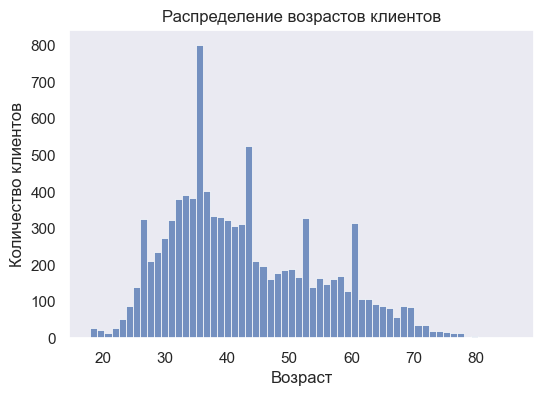

In [32]:
plt.figure(figsize = (6,4))
sns.histplot(data = df, x = 'age',bins = 60)
plt.title('Распределение возрастов клиентов')
plt.ylabel('Количество клиентов')
plt.xlabel('Возраст')
plt.show()

Судя по гистограмме, пропуски не зависят от возраста.

Создадим новый столбец, который принимает значение "1", если значение пропущено, и "0", если значение не пропущено.

In [35]:
df['age_isna'] = df['age'].isna().astype('int')

In [36]:
df.query('age.isna()').head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_isna
1247,228075,932,Ярославль,М,<NA>,5,7601719.20,2,1,1,408121.16,0,1
2165,187635,692,Рыбинск,Ж,<NA>,0,NaN,1,1,1,160368.82,0,1
2444,221156,913,Ярославль,М,<NA>,0,NaN,1,1,1,135693.24,0,1
3091,138660,836,Ростов,Ж,<NA>,5,294315.53,2,0,1,63310.22,1,1
4912,210674,834,Рыбинск,М,<NA>,1,238330.52,2,0,1,93775.06,0,1


Столбец успешно создан. Посмотрим на корреляцию пропусков с другими признаками.

Построить матрицу корреляций, если там есть категориальные переменные, нельзя. Однако мы можем заменить категории числовыми лейблами.

In [39]:
df_numeric = pd.get_dummies(df[['city','gender']])

Сохраним количественные значения в отдельной переменной.

In [41]:
df_numeric = df[['score','age','equity','balance','products','credit_card','last_activity',\
'salary','churn','age_isna']].join(df_numeric)

In [42]:
df_numeric.head(3)

,score,age,equity,balance,products,credit_card,last_activity,salary,churn,age_isna,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,850,25,1,59214.82,2,0,1,75719.14,1,0,False,True,False,True,False
1,861,37,5,850594.33,3,1,0,86621.77,0,0,False,True,False,True,False
2,892,30,0,NaN,1,1,1,107683.34,0,0,False,True,False,True,False


Построим матрицу корреляций для нового столбца

In [44]:
df_numeric.corr()['age_isna']

score             0.005035
age                    NaN
equity           -0.032040
balance           0.007686
products         -0.033751
credit_card       0.009726
last_activity     0.025120
salary            0.011252
churn            -0.018994
age_isna          1.000000
city_Ростов      -0.015114
city_Рыбинск      0.022098
city_Ярославль   -0.009214
gender_Ж         -0.003876
gender_М          0.003876
Name: age_isna, dtype: float64

Корреляции между пропусками и другими переменными не обнаружено. Пропуски случайны. Заполнять не будем.

Посмотрим на пропуски столбца "balance".

In [47]:
balance_na = df.query('balance.isna()')
balance_na

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_isna
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0
9,133130,906,Ярославль,Ж,67,0,NaN,1,0,1,238055.53,0,0
10,148929,927,Ростов,М,52,0,NaN,1,1,1,196820.07,0,0
11,172184,921,Ростов,М,41,0,NaN,1,1,1,217469.48,0,0
19,127034,922,Рыбинск,Ж,53,0,NaN,1,0,0,147094.82,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9976,208085,876,Ростов,М,38,0,NaN,1,0,0,171763.69,0,0
9984,125941,729,Ярославль,Ж,42,0,NaN,1,1,1,687538.70,0,0
9993,219924,884,Рыбинск,Ж,36,0,NaN,1,1,1,169844.88,0,0
9996,139170,894,Ярославль,М,46,0,NaN,1,1,0,196898.29,0,0


Судя по данному фрагменту, пользователи с пропущенными значениями баланса имеют 0 баллов собственности и в большинстве случаев количество продуктов, равное 1. Проверим так ли это.

Построим также матрицу корреляции для отсутсвующих значений в данном признаке.

In [50]:
df_numeric['balance_isna'] = df['balance'].isna().astype('int')

In [51]:
df_numeric.head(3)

,score,age,equity,balance,products,credit_card,last_activity,salary,churn,age_isna,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М,balance_isna
0,850,25,1,59214.82,2,0,1,75719.14,1,0,False,True,False,True,False,0
1,861,37,5,850594.33,3,1,0,86621.77,0,0,False,True,False,True,False,0
2,892,30,0,NaN,1,1,1,107683.34,0,0,False,True,False,True,False,1


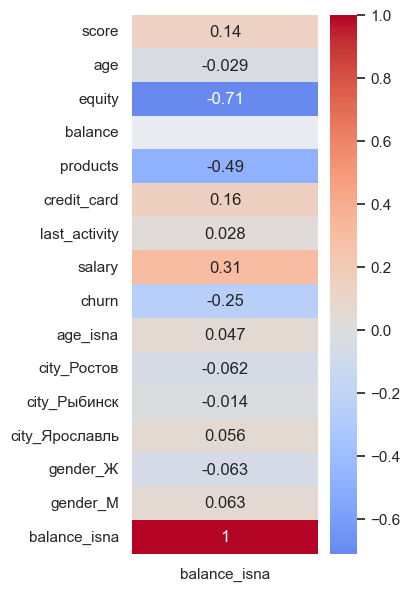

In [52]:
corr = df_numeric.corr()
plt.figure(figsize = (3,7))
sns.heatmap(data = corr[['balance_isna']], cmap = 'coolwarm', center = 0, annot = True)
plt.show()

График показывает высокую корреляцию признака со столбцами `equity` и `products`. 

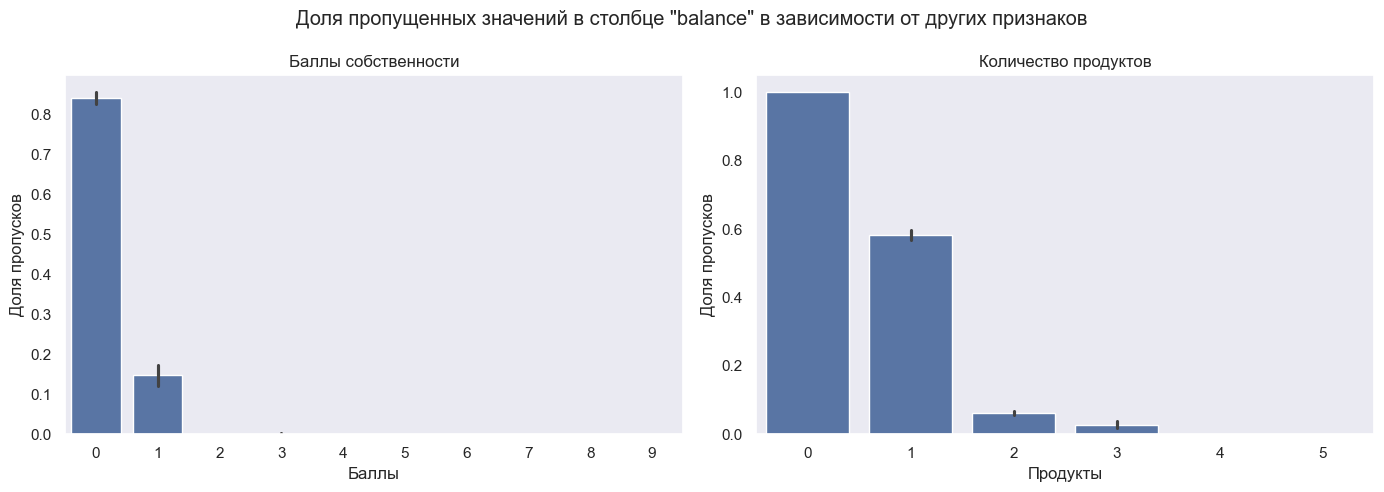

In [54]:
fig, axs = plt.subplots(1,2, figsize = (14,5))
sns.barplot(data = df_numeric, x = 'equity', y = 'balance_isna', ax = axs[0])
axs[0].set_xlabel('Баллы')
axs[0].set_title ('Баллы собственности')
sns.barplot(data = df_numeric, x = 'products', y = 'balance_isna', ax = axs[1])
axs[1].set_xlabel('Продукты')
axs[1].set_title ('Количество продуктов')
for ax in axs.flat:
    ax.set_ylabel('Доля пропусков')
fig.suptitle ('Доля пропущенных значений в столбце "balance" в зависимости от других признаков')
plt.tight_layout()
plt.show()

Пропуски в балансах зависят от пропусков в столбцах `equity` и `products`. Оставим пропуски как есть, поскольку заполнение может исказить результаты.

### Обработка дубликатов

Проверим наличие в датафрейме явных дубликатов.

In [58]:
df.duplicated().sum()

0

Явных дубликатов в датафрейме нет

Проверим поля на наличие неявных дубликатов. Начнем с ID пользователей.

In [61]:
df['user_id'].value_counts()

user_id
141265    2
217826    2
126368    2
195884    2
202983    2
         ..
199413    1
205705    1
221433    1
152512    1
96267     1
Name: count, Length: 9927, dtype: int64

В датафрейме дублирующиеся id. Посмотрим на них с другими параметрами.

In [63]:
display(df[df['user_id'].duplicated(keep = False)].sort_values(by = 'user_id').head(10))
df[df['user_id'].duplicated(keep = False)].sort_values(by = 'user_id').tail(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_isna
1893,116540,883,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1,0
7694,116540,887,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0,0
7542,117943,880,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0,0
4866,117943,855,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1,0
5896,120258,905,Ярославль,М,30,0,NaN,1,1,1,146427.96,0,0
5863,120258,908,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1,0
1411,123461,829,Ярославль,Ж,59,0,96222.44,2,0,1,102771.55,1,0
8638,123461,934,Рыбинск,М,34,0,NaN,2,1,0,291619.27,0,0
8164,124450,859,Ярославль,Ж,38,6,516811.20,1,1,1,95144.63,1,0
9775,124450,758,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0,0


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,age_isna
9104,222480,776,Рыбинск,Ж,<NA>,5,796735.09,1,1,1,55073.63,0,1
6446,222480,776,Ярославль,Ж,38,5,823145.83,2,1,1,55777.44,0,0
8070,226550,940,Рыбинск,М,<NA>,0,NaN,1,0,1,147696.95,0,1
6412,226550,939,Ярославль,М,34,0,NaN,1,1,1,145913.73,0,0
4216,226719,903,Рыбинск,Ж,63,0,NaN,1,1,0,138582.58,0,0
2597,226719,990,Ярославль,М,37,4,14648692.14,2,0,0,934412.61,1,0
8205,227795,840,Рыбинск,М,34,2,350768.03,1,1,0,102036.14,1,0
8497,227795,839,Ярославль,М,34,2,326593.14,2,1,0,103314.92,0,0
6457,228075,839,Рыбинск,М,39,5,507199.85,3,0,1,85195.80,0,0
1247,228075,932,Ярославль,М,<NA>,5,7601719.20,2,1,1,408121.16,0,1


Как видно из среза, продублированы только сами идентификаторы, данные в них разнятся. Похоже на то, что номера продублированы по ошибке. Оставим данные как есть.

Проверим неявные дубликаты столбцов с названием города и полом.

In [66]:
df['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [67]:
df['gender'].unique()

array(['Ж', 'М'], dtype=object)

В данных столбцах неявных дубликатов нет.

Датасет проверен на наличие дубликатов.

Проверим на общую информацию датафрейма после проведенных операций.

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  Int64  
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   Int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  salary         10000 non-null  float64
 11  churn          10000 non-null  int64  
 12  age_isna       10000 non-null  int32  
dtypes: Int64(2), float64(2), int32(1), int64(6), object(2)
memory usage: 996.2+ KB


Данные не потеряны. 

В датафрейм добавлены новые столбцы с числовыми лейблами, которые будут нужны при построении матрицы корреляций признаков и машинного обучения, однако при исследовательском анализе данных они будут влиять на быстродействие, поэтому удалим их из основного датафрейма "df" (столбцы с числовыми лейблами уже сохранены в переменной "df_numeric").

In [73]:
df = df.drop(['age_isna'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  Int64  
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   Int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  salary         10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: Int64(2), float64(2), int64(6), object(2)
memory usage: 957.2+ KB


In [74]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   score           10000 non-null  Int64  
 1   age             9974 non-null   Int64  
 2   equity          10000 non-null  int64  
 3   balance         7705 non-null   float64
 4   products        10000 non-null  int64  
 5   credit_card     10000 non-null  int64  
 6   last_activity   10000 non-null  int64  
 7   salary          10000 non-null  float64
 8   churn           10000 non-null  int64  
 9   age_isna        10000 non-null  int32  
 10  city_Ростов     10000 non-null  bool   
 11  city_Рыбинск    10000 non-null  bool   
 12  city_Ярославль  10000 non-null  bool   
 13  gender_Ж        10000 non-null  bool   
 14  gender_М        10000 non-null  bool   
 15  balance_isna    10000 non-null  int32  
dtypes: Int64(2), bool(5), float64(2), int32(2), int64(5)
memory usage: 849.7 KB


Лишние столбцы удалены из датафрейма.

## Исследовательский анализ данных

### Анализ непрерывных количественных признаков

Построим гистограммы для количественных признаков. Чтобы не писать один и тот же код каждый раз, напишем функцию для создания гистограммы с необходимыми параметрами и подписями

In [79]:
def hist(x):
    plt.figure(figsize = (6,5))
    sns.histplot(data = df, x = x, hue = 'churn', stat = 'density', common_norm = False)
    plt.ylabel('Плотность распределения')
    plt.legend(title = 'Факт оттока', labels = ['Да','Нет'])

Проанализируем распределение баллов кредитного скоринга в разрезе оттока.

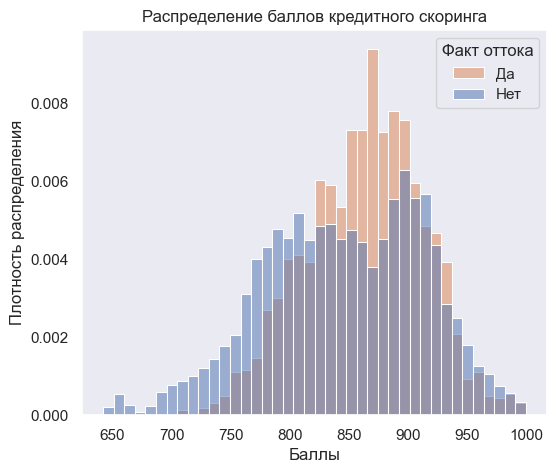

In [81]:
hist('score')
plt.xlabel('Баллы')
plt.title('Распределение баллов кредитного скоринга')
plt.show()

Наиболее склонны к оттоку пользователи с баллом выше среднего

Построим график распределения возрастов клиентов в разрезе оттока

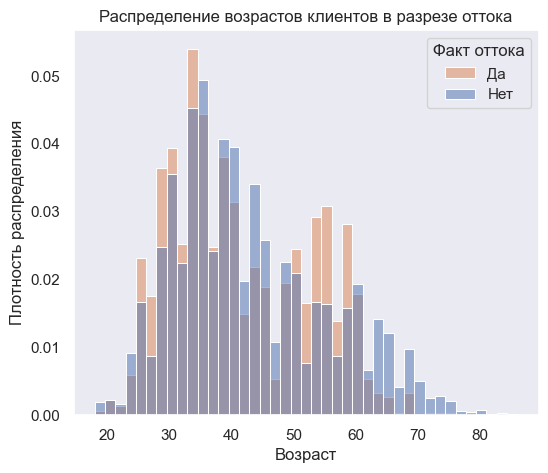

In [84]:
hist('age')
plt.xlabel('Возраст')
plt.title('Распределение возрастов клиентов в разрезе оттока')
plt.show()

Судя по данной гистограмме, клиенты возраста 50-60 лет склонны чаще переставать пользоваться услугами банка, чем оставаться в нем

Рассмотрим распределение балансов на счете клиентов в разрезе оттока.

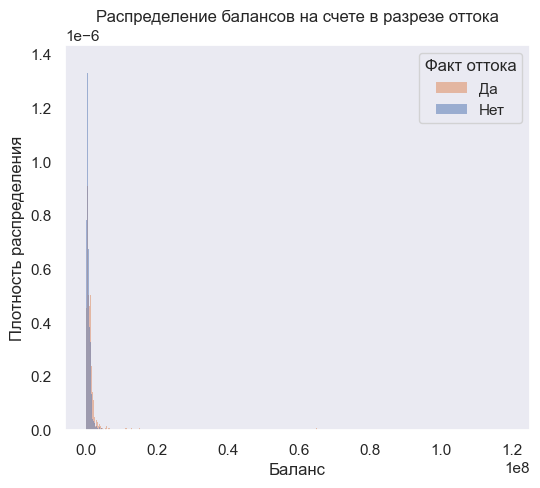

In [87]:
hist('balance')
plt.xlabel('Баланс')
plt.title('Распределение балансов на счете в разрезе оттока')
plt.show()

Данные смещены вправо. Это говорит о наличии выбросов. Сделаем график более читаемым: сократим крайнее значение баланса до 5 млн. рублей

<Figure size 700x700 with 0 Axes>

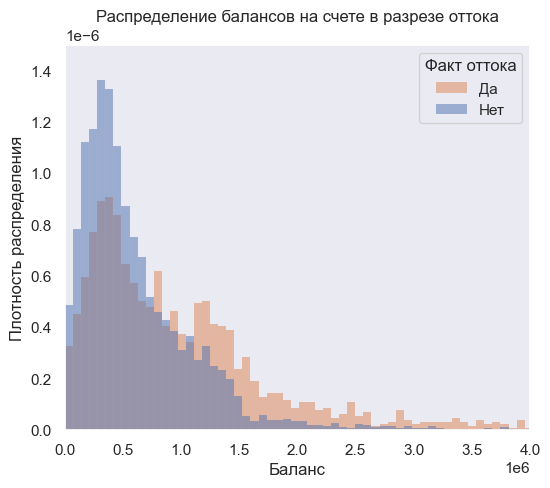

In [89]:
plt.figure(figsize =(7,7))
hist('balance')
plt.xlabel('Баланс')
plt.title('Распределение балансов на счете в разрезе оттока')
plt.xlim(0,4000000)
plt.ylim(0,0.0000015)
plt.show()

На гистограмме видно, что к оттоку склонны пользователи с более высоким балансом на счете (примерно от 800 тыс.)

Визуализируем распределение оценочных доходов клиентов в разрезе оттока.

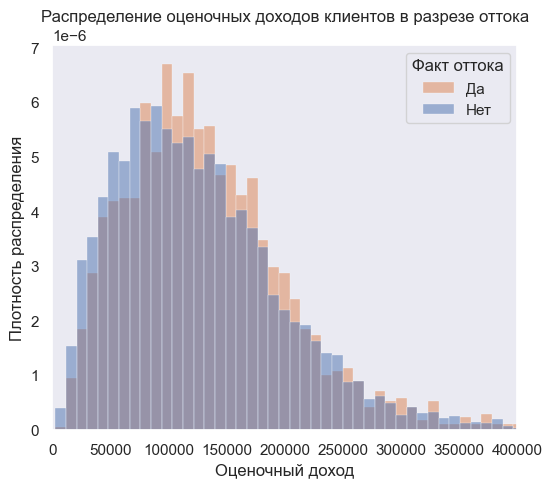

In [92]:
hist('salary')
plt.xlabel('Оценочный доход')
plt.title('Распределение оценочных доходов клиентов в разрезе оттока')
plt.xlim(0,400000) # в данных есть выбросы, ограничим ось X сразу
plt.show()

Наиболее склонны к оттоку пользователи с медианным и выше оценочным доходом. Медианный доход описан в вызове метода .describe() и равен примерно ~120 тыс.

### Анализ дискретных и категориальных признаков

Все признаки будем сравнивать со средним значением оттока по банку равному 18,2%.

Как и в предыдущем пункте, создадим функцию для построения графиков, чтобы не писать постоянно один и тот же код.

In [97]:
def bar(x):
    sns.barplot(data = df, x = x, y = 'churn', errorbar = None)
    plt.axhline(y = df['churn'].mean(), linestyle = '--', color = 'red', label = 'Средняя доля оттока по банку')
    plt.legend()
    plt.ylabel('Доля оттока')

Сравним долю оттока для клиентов разных городов.

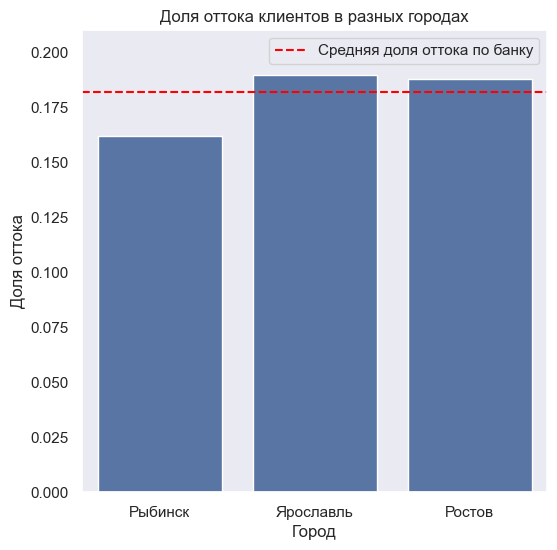

In [99]:
bar('city')
plt.xlabel('Город')
plt.title('Доля оттока клиентов в разных городах')
plt.ylim(0,0.21)
plt.show()

Доля оттока для жителей Ярослава и Рыбинска превышает среднюю по банку (изображена в виде горизонтальной красной линии).

Проанализируем долю оттока для двух полов.

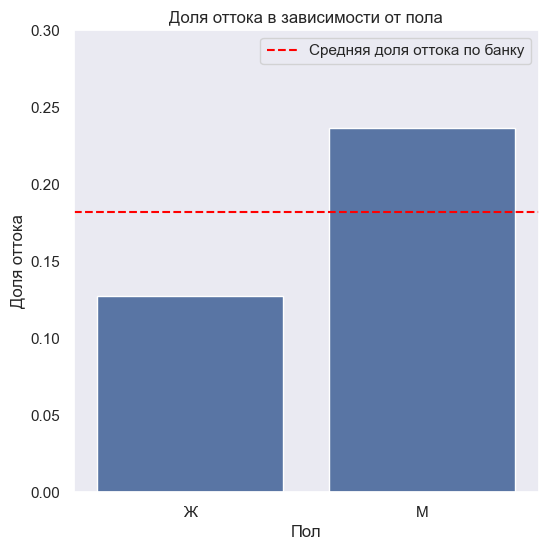

In [102]:
bar('gender')
plt.xlabel('Пол')
plt.title('Доля оттока в зависимости от пола')
plt.ylim(0,0.3)
plt.show()

Доля оттока мужчин превышает среднюю по банку.

Проанализируем отток в зависимости от количества баллов собственности

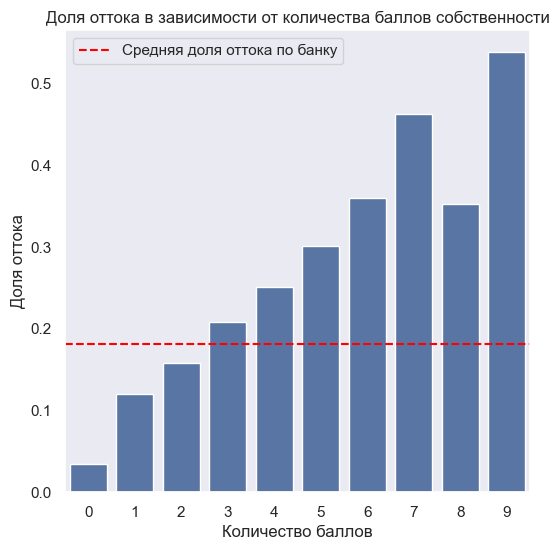

In [105]:
bar('equity')
plt.xlabel('Количество баллов')
plt.title('Доля оттока в зависимости от количества баллов собственности')
plt.show()

Среднюю долю оттока превышают все категории с количестом баллов выше 2. При этом виден тренд: чем больше баллов собственности, тем выше доля оттока.

Проанализируем как влияет количество продуктов банка, которыми пользуется клиент, на долю оттока.

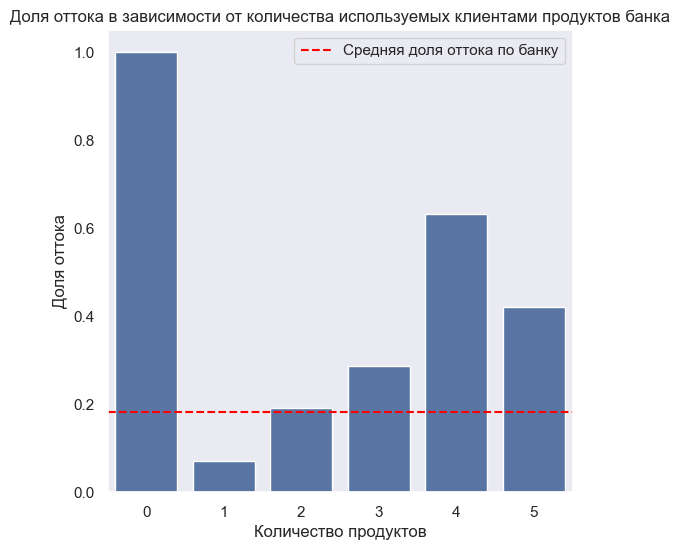

In [108]:
bar('products')
plt.xlabel('Количество продуктов')
plt.title('Доля оттока в зависимости от количества используемых клиентами продуктов банка')
plt.show()

In [109]:
df['products'].value_counts()

products
2    5126
1    3341
3    1039
4     474
5      19
0       1
Name: count, dtype: int64

Высокий уровень оттока наблюдается также у клиентов с количеством продуктов равным от 3 до 5. Доля оттока пользователей с двумя продуктами также превышает среднюю по банку.

Удалим из датафрейма пользователя с нулевым количеством продуктов.

In [112]:
df = df[df['products']!=0]

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9999 non-null   int64  
 1   score          9999 non-null   Int64  
 2   city           9999 non-null   object 
 3   gender         9999 non-null   object 
 4   age            9973 non-null   Int64  
 5   equity         9999 non-null   int64  
 6   balance        7705 non-null   float64
 7   products       9999 non-null   int64  
 8   credit_card    9999 non-null   int64  
 9   last_activity  9999 non-null   int64  
 10  salary         9999 non-null   float64
 11  churn          9999 non-null   int64  
dtypes: Int64(2), float64(2), int64(6), object(2)
memory usage: 1.0+ MB


Успешно

Изучим долю оттока в зависимости от наличия кредитной карты банка.

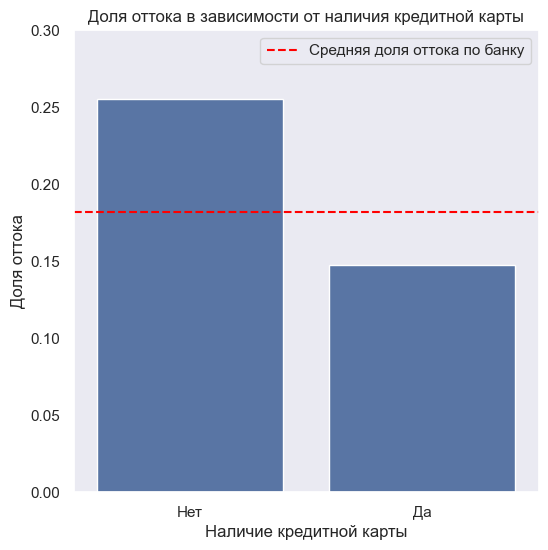

In [116]:
bar('credit_card')
plt.xlabel ('Наличие кредитной карты')
plt.title ('Доля оттока в зависимости от наличия кредитной карты')
plt.xticks(ticks = [0,1],labels = ['Нет','Да'])
plt.ylim(0,0.3)
plt.show()

Средний отток по банку превышают клиенты без кредитной карты 

Рассмотрим долю оттока в зависимости от активности клиента

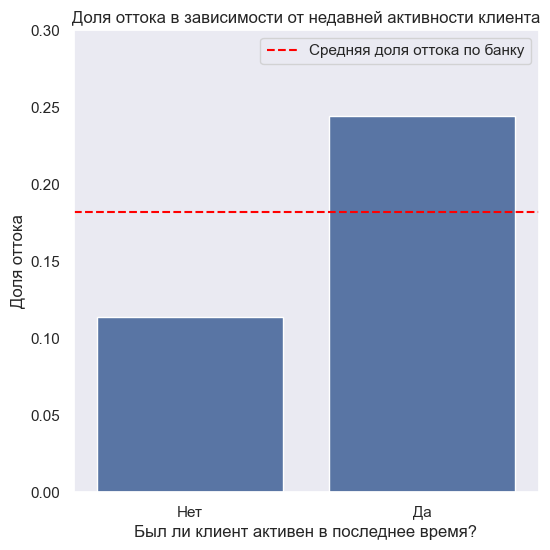

In [119]:
bar('last_activity')
plt.title('Доля оттока в зависимости от недавней активности клиента')
plt.xlabel('Был ли клиент активен в последнее время?')
plt.xticks(ticks = [0,1],labels = ['Нет','Да'])
plt.ylim(0,0.3)
plt.show()

Более активные клиенты чаще перестают пользоваться услугами банка

### Портреты клиентов

Создадим таблицу со следующей структурой: индексами будут служить признаки клиентов, в столбцах будет отображена мера цетральной тенденции для ушедших и оставшихся пользователей, название меры, относительная разница.

Создадим "скелет" таблицы.

In [124]:
# признаки сохраним в виде списка
features = df.T.drop(['user_id','churn'], axis = 0).index.to_list()
# создаем таблицу
portrait = pd.DataFrame(columns = ['Признак','Отток','Не отток','Мера ЦТ','Относительная разница'])
portrait['Признак'] = features
portrait = portrait.set_index('Признак')

In [125]:
portrait

,Отток,Не отток,Мера ЦТ,Относительная разница
Признак,,,,
score,NaN,NaN,NaN,NaN
city,NaN,NaN,NaN,NaN
gender,NaN,NaN,NaN,NaN
age,NaN,NaN,NaN,NaN
equity,NaN,NaN,NaN,NaN
balance,NaN,NaN,NaN,NaN
products,NaN,NaN,NaN,NaN
credit_card,NaN,NaN,NaN,NaN
last_activity,NaN,NaN,NaN,NaN


"Скелет" таблицы создан. Добавим в нее данные. Сделаем это, создав функцию и применив ее к методу .apply()

In [127]:
# непрерывные признаки
continious_data = ['score','balance','salary']
# дискретные признаки
discrete_data = ['age','equity','products']
# категориальные признаки
categorical_data = ['city','gender','credit_card','last_activity']

In [128]:
# функция возвращает для каждого признака меру центральной тенденции для оттока, меру ц.т. для не оттока, 
# название меры ц.т. и разность значений мер
def add_measure(row):
# f - название признака
    f = row.name
# срез с данными оттока
    churn_data = df[df['churn']==1]
# срез с данными оставшихся клиентов
    no_churn_data = df[df['churn']==0]
# для непрерывных данных считаем среднее    
    if f in continious_data:
        churn = churn_data[f].mean().round(2)
        no_churn = no_churn_data[f].mean().round(2)
# у признаков "balance" и "salary" есть выбросы, поэтому для них посчитаем также и медиану
        if f == 'balance' or f == 'salary':
            churn_median = round(churn_data[f].median())
            no_churn_median = round(no_churn_data[f].median())
            diff = round(churn-no_churn,2)
            churn_par = str(churn) + f' ({churn_median})'
            no_churn_par = str(no_churn) + f' ({no_churn_median})'
            diff_par = str(diff) + f' ({churn_median - no_churn_median})'
            return churn_par, no_churn_par,'Среднее (медиана)', diff_par
        else:
            return churn, no_churn, 'Среднее', churn - no_churn
# для дискретных признаков считаем медиану
    if f in discrete_data:
        churn = churn_data[f].median()
        no_churn = no_churn_data[f].median()
        return churn, no_churn, 'Медиана', churn - no_churn
# для категориальных данных узнаем моду
    if f in categorical_data:
        churn = churn_data[f].mode().iloc[0]
        no_churn = no_churn_data[f].mode().iloc[0]
        return churn,no_churn,'Мода', 'Не применимо'

Применим написанную функцию

In [130]:
portrait[['Отток','Не отток','Мера ЦТ','Относительная разница']] = portrait.apply(add_measure,axis = 1,\
result_type='expand')

In [131]:
portrait

,Отток,Не отток,Мера ЦТ,Относительная разница
Признак,,,,
score,863.35,845.43,Среднее,17.92
city,Ярославль,Ярославль,Мода,Не применимо
gender,М,Ж,Мода,Не применимо
age,39.0,40.0,Медиана,-1.0
equity,4.0,3.0,Медиана,1.0
balance,1133993.27 (782410),733982.59 (475382),Среднее (медиана),400010.68 (307028)
products,2.0,2.0,Медиана,0.0
credit_card,1,1,Мода,Не применимо
last_activity,1,0,Мода,Не применимо


Таблица готова.

Анализ показывает, что доля ушедших мужчин превышает среднюю по банку и ушедшие пользователи в основном предствлены мужчинами, но стоит узнать является ли сам факт половой принадлежности важным признаком или преобладание мужского пола связано с другими факторами.

Возможно мужчины преобладают в оттоке потому что обладают более высокими финансами. Посмотрим на распределение балансов и зарплат в зависимости от пола.

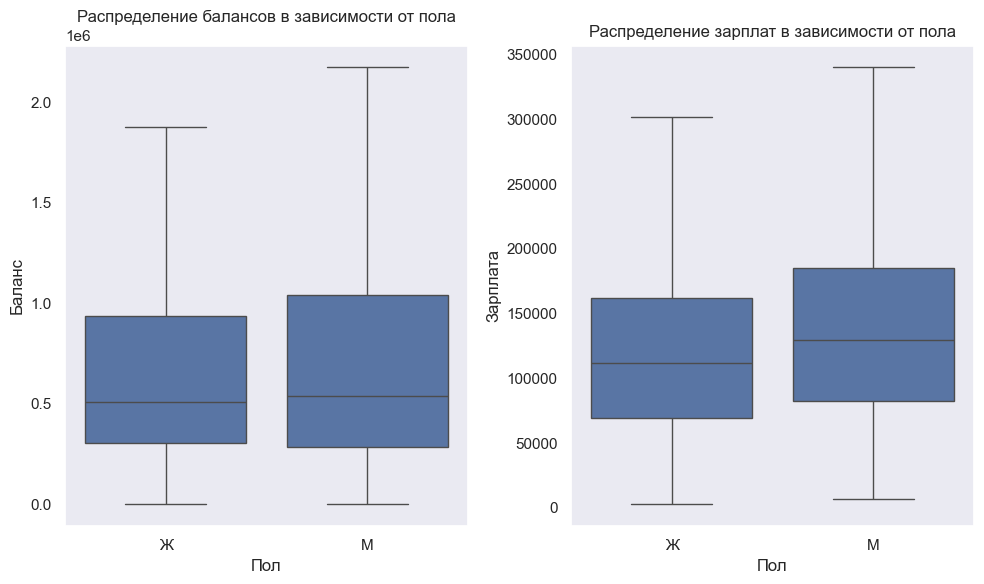

In [135]:
fig, axs = plt.subplots(1,2, figsize = (10,6))
sns.boxplot(data = df, x = 'gender', y = 'balance', showfliers = False, ax = axs[0])
axs[0].set_title ('Распределение балансов в зависимости от пола')
axs[0].set_ylabel('Баланс')
sns.boxplot(data = df, x = 'gender', y = 'salary', showfliers = False, ax = axs[1])
axs[1].set_title('Распределение зарплат в зависимости от пола')
axs[1].set_ylabel('Зарплата')
for ax in axs.flat:
    ax.set(xlabel = 'Пол')
plt.tight_layout()
plt.show()

Балансы на счете для мужчин и женщин распределены примерно одинаково. Оценочные зарплаты распределены выше, но незначительно.

Возможно на результаты влияют мужчины со сверхдоходами. Посмотрим на средний баланс и зарплату у мужчин и женщин.

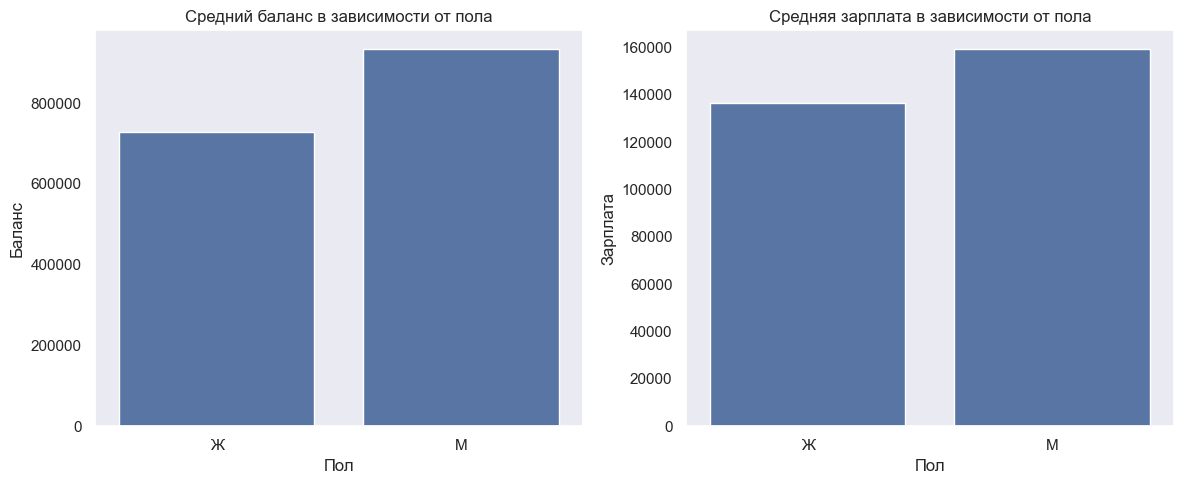

In [138]:
gender_balance = df.groupby('gender')['balance'].mean().reset_index()
gender_salary = df.groupby('gender')['salary'].mean().reset_index()
fig, axs = plt.subplots(1,2, figsize = (12,5))
sns.barplot(data = gender_balance, x = 'gender', y = 'balance', ax = axs[0])
axs[0].set_title('Средний баланс в зависимости от пола')
axs[0].set_ylabel('Баланс')
sns.barplot(data = gender_salary, x = 'gender', y = 'salary', ax = axs[1])
axs[1].set_title('Средняя зарплата в зависимости от пола')
axs[1].set_ylabel('Зарплата')
for ax in axs.flat:
    ax.set(xlabel = 'Пол')
plt.tight_layout()
plt.show()

Средние балансы и зарплаты мужчин выше, чем у женщин. Есть влияние мужчин с аномально высокими доходами.

Посмотрим как распределены балансы и зарплаты на диаграмме рассеяния.

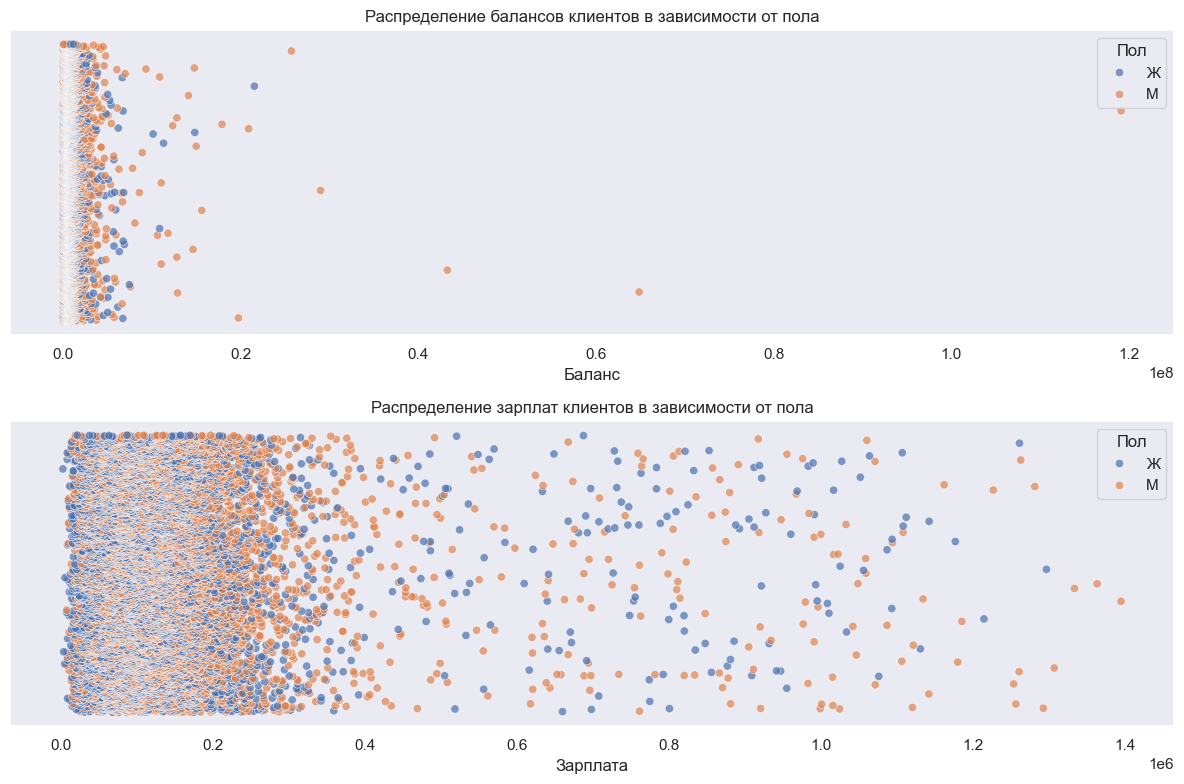

In [141]:
fig, axs = plt.subplots(2,1,figsize = (12,8))
# выделим каждый пол отдельным цветом
sns.scatterplot(data = df, x = 'balance', y = df.index, alpha = 0.7, hue = 'gender', ax = axs[0])
axs[0].set_title('Распределение балансов клиентов в зависимости от пола')
axs[0].set_xlabel('Баланс')
sns.scatterplot(data = df, x = 'salary', y = df.index, alpha = 0.7, hue = 'gender', ax = axs[1])
axs[1].set_title('Распределение зарплат клиентов в зависимости от пола')
axs[1].set_xlabel('Зарплата')
for ax in axs.flat:
    ax.set(ylabel = '', yticks = [])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles = handles, title = 'Пол', labels = ['Ж','М'])
plt.tight_layout()
plt.show()

Среди людей со сверхвысокими балансами действительно доминируют мужчины, однако среди людей со сверхвысокими доходами нет явной доминации мужского пола.
Вряд ли маленький процент людей со сверхвысоким балансом влияет на высокую отточность мужчин в целом.

Посмотрим как распределены баллы собственности.

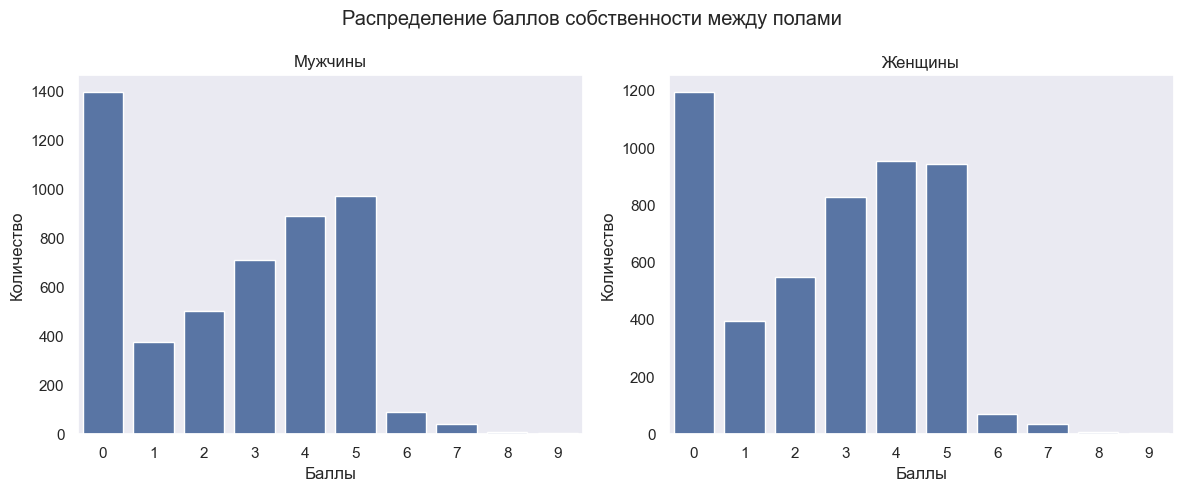

In [144]:
fig, axes = plt.subplots (1,2, figsize = (12,5))
men = df[df['gender']=='М'].groupby('equity')['gender'].count().reset_index()
women = df[df['gender']=='Ж'].groupby('equity')['gender'].count().reset_index()
sns.barplot(data = men, x = 'equity', y = 'gender', ax = axes[0])
axes[0].set_title('Мужчины')
sns.barplot(data = women, x = 'equity', y = 'gender', ax = axes[1])
axes[1].set_title('Женщины')
for ax in axes.flat:
    ax.set(xlabel='Баллы', ylabel='Количество')
fig.suptitle('Распределение баллов собственности между полами')
plt.tight_layout()
plt.show()

Заметных отличий между мужчинами и женщинами нет.

Таким образом, половая принадлежность сама по себе является важным признаком, влиящим на отток.

Главные различия между ушедшими и оставшимися клиентами в данной таблице: в половой принадлежности, активности и балансе на счете (активные недавно мужчины и люди с более высоким балансом на счете склонны переставать пользоваться услугами банка).

### Корреляционный анализ

Построим матрицу корреляций методом phik.

In [149]:
# данный метод строит матрицу для категориальных и количественных (непрерывных и дискретных) переменных, 
# однако для правильной работы методу важно отличать числовые переменные от категориальных. Метод может определить
# данные виды переменных автоматически, но для точности укажем их вручную
interval_cols = ['score','age','equity','balance','products','salary']
phik_corr = df_numeric.phik_matrix(interval_cols = interval_cols).round(2)

Матрица сохранена в переменной "phik_corr", построим на ее основе тепловую карту.

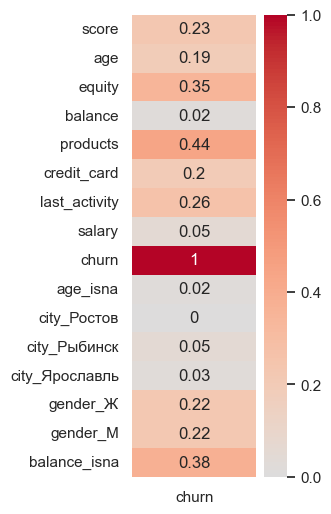

In [151]:
plt.figure(figsize = (2,6))
sns.heatmap(data = phik_corr[['churn']], cmap = 'coolwarm', center = 0, annot = True)
plt.show()

Наиболее высоко с параметром оттока коррелируют параметры "produсts" (количество продуктов компании, которыми пользуются пользователи) и "equity" (количество баллов собственности). На отток в меньшей степени влияют параметры "last_activity", "score", "gender", "credit_card" и "age".

## Проверка статистических гипотез

### Гипотеза о равенстве средних доходов

Проверим гипотезу о равенстве средних доходов у оставшихся и ушедших клиентов. 

Существуют разные способы проверки гипотез. Один из них - статистический тест с использованием t-распределения Стьюдента (t-тест),
однако использовать данный тест можно при соблюдении выборками нескольких критериев. Проверим их.

Сформируем выборки

In [157]:
# оценочные доходы ушедших клиентов
churn_salary = df[df['churn']==1]['salary'].copy()
# оценочные доходы оставшихся клиентов
no_churn_salary = df[df['churn']==0]['salary'].copy()

Один из критериев теста - независимость выборок. Как правило, зависимые выборки связаны между собой во времени, например, если признак для одних и тех же пользователей есть для одного месяца и для другого. В данном датасете такого нет, каждый пользователь представлен один раз. Соответсвенно по данному критерию выборки соответствуют.

Это справедливо для всех выборок из данного датасета.

Проверим нормальность распределения для двух выборок, но сначала создадим функцию, которая отрисывовывает попарные гистограммы для двух выборок.

In [160]:
# функция принимает на вход выборку с оттоком, выборку без оттока, подпись осей X, название графика,
# а также значение True, если необходимо нарисовать линию поверх гистограммы
def stat_hist(churn, no_churn, xlabel, suptitle, kde = None):
    fig, axs = plt.subplots(1,2, figsize = (14,6))
    if kde == True:
        sns.histplot(data = churn, bins = 50, ax = axs[0], kde = True)
        sns.histplot(data = no_churn, bins = 50, ax = axs[1], kde = True)
    else:
        sns.histplot(data = churn, bins = 50, ax = axs[0])
        sns.histplot(data = no_churn, bins = 50, ax = axs[1])
    for ax in axs.flat:
        ax.set(xlabel=xlabel, ylabel='Количество клиентов')
    axs[0].set_title('Выборка с оттоком')
    axs[1].set_title('Выборка без оттока')
    if suptitle:  
        fig.suptitle(suptitle)
    plt.tight_layout()

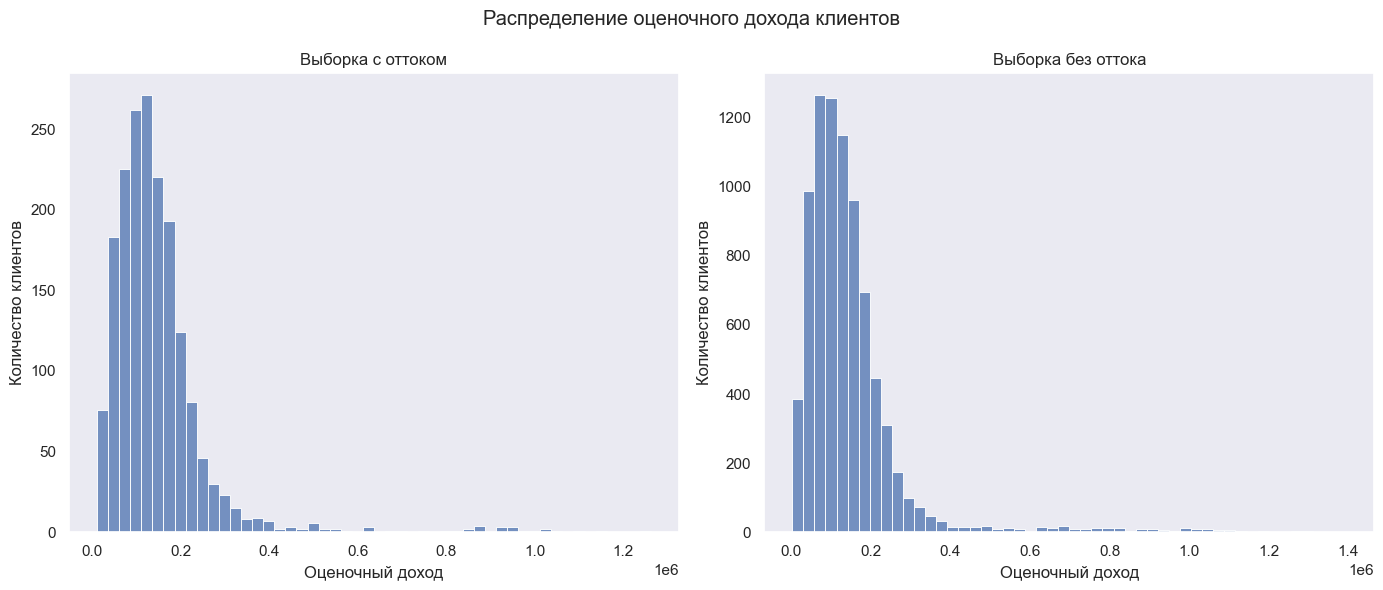

In [161]:
stat_hist(churn_salary, no_churn_salary, 'Оценочный доход','Распределение оценочного дохода клиентов')

В обоих выборках присутствуют выбросы. Выборки нужно отфильтровать. Посмотрим на 95, 97,5 и 99 перцентили обоих выборок.

In [163]:
print(np.percentile(churn_salary,[95,97.5,99]))
print(np.percentile(no_churn_salary,[95,97.5,99]))

[304044.812  412038.6815 857269.0688]
[321003.7465  567563.80875 906141.8267 ]


Отфильтруем выборки по 90-му перцентилю.

In [165]:
churn_salary = churn_salary[churn_salary <= 305000]
no_churn_salary = no_churn_salary[no_churn_salary <= 322000]

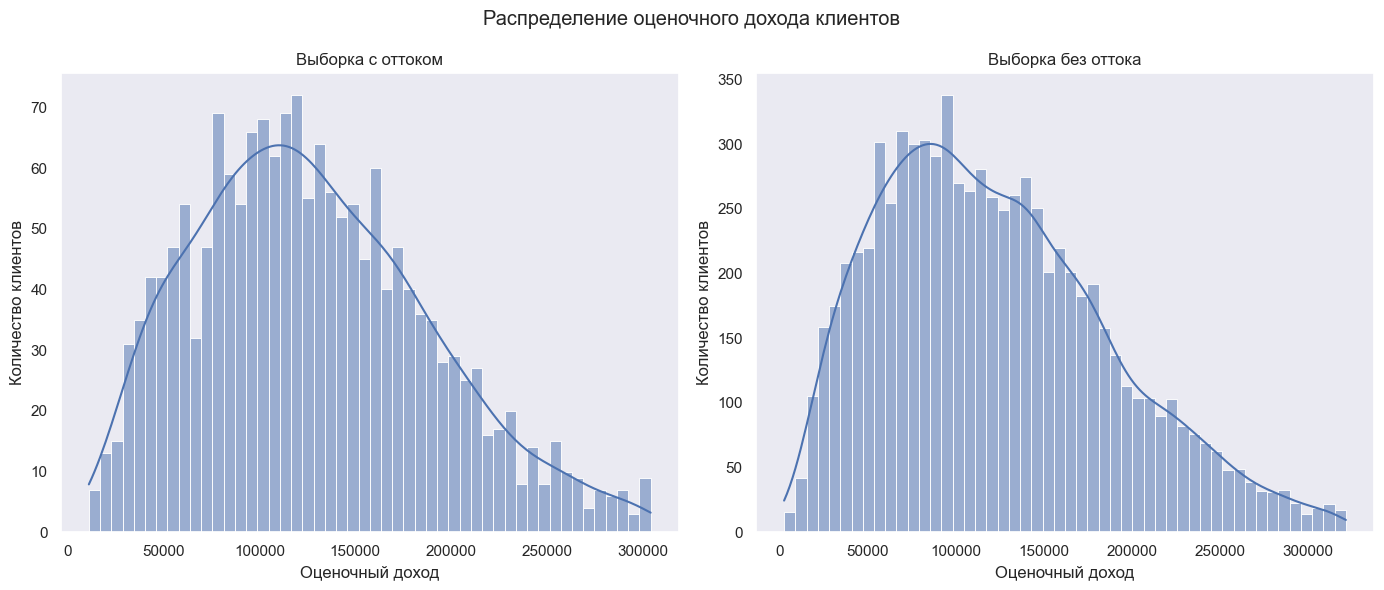

In [166]:
stat_hist(churn_salary, no_churn_salary, 'Оценочный доход','Распределение оценочного дохода клиентов', True)

От выбросов избавились, выборки распределены нормально.

Сравним размеры выборок

In [169]:
churn_len = len(churn_salary)
no_churn_len = len(no_churn_salary)
print(f'Размер выборки с пользователями с оттоком: {churn_len}')
print(f'Размер выборки с пользователями без оттока: {no_churn_len}')

Размер выборки с пользователями с оттоком: 1730
Размер выборки с пользователями без оттока: 7774


Размеры выборок заметно отличаются, поэтому в тесте будем использовать параметр "equal_var = False"

Выборки по всем критериям подходят к проведению t-теста

Сформулируем гипотезы

Нулевая гипотеза: средние оценочные доходы у ушедших и оставшихся клиентов равны

Альтернативная гипотеза: средние оценочные доходы у ушедших и оставшихся клиентов не равны

Уровень статистической значимости установим на уровне 5%.

In [173]:
alpha = 0.05
results = st.ttest_ind(churn_salary, no_churn_salary, equal_var = False)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.0008442742034414766
Отвергаем нулевую гипотезу


P-value меньше значения alpha - гипотезу о равенстве средних оценочных доходов между двумя группами отвергаем.

На основе данных выборок можно проверить другую гипотезу: о том, что у ушедших пользователей более высокий оценочный средний доход.

Нулевая гипотеза: средние оценочные доходы ушедших пользователей не выше, чем у оставшихся

Альтернативная гипотеза: средние оценочные доходы ушедших пользователей выше, чем у оставшихся

In [176]:
# уровень статистической значимости оставим равным 5%
# поскольку альтернативная гипотеза одностороняя и говорит о том, что среднее значение первой выборки выше второй, 
# устанавливаем параметр "alternative  = 'greater'"
results = st.ttest_ind(churn_salary, no_churn_salary, equal_var = False, alternative  = 'greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.0004221371017207383
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута. Есть основания говорить, что у ушедших пользователей доход выше.

### Гипотеза о равенстве средних баллов кредитного скоринга

Следующая гипотеза предполагает равенство баллов кредитного скоринга для ушедших и оставшихся клиентов.

Проверим выборки на возможность применения t-теста.

In [181]:
# сохраним выборки в переменных
churn_score = df[df['churn']==1]['score'].to_list()
no_churn_score = df[df['churn']==0]['score'].to_list()

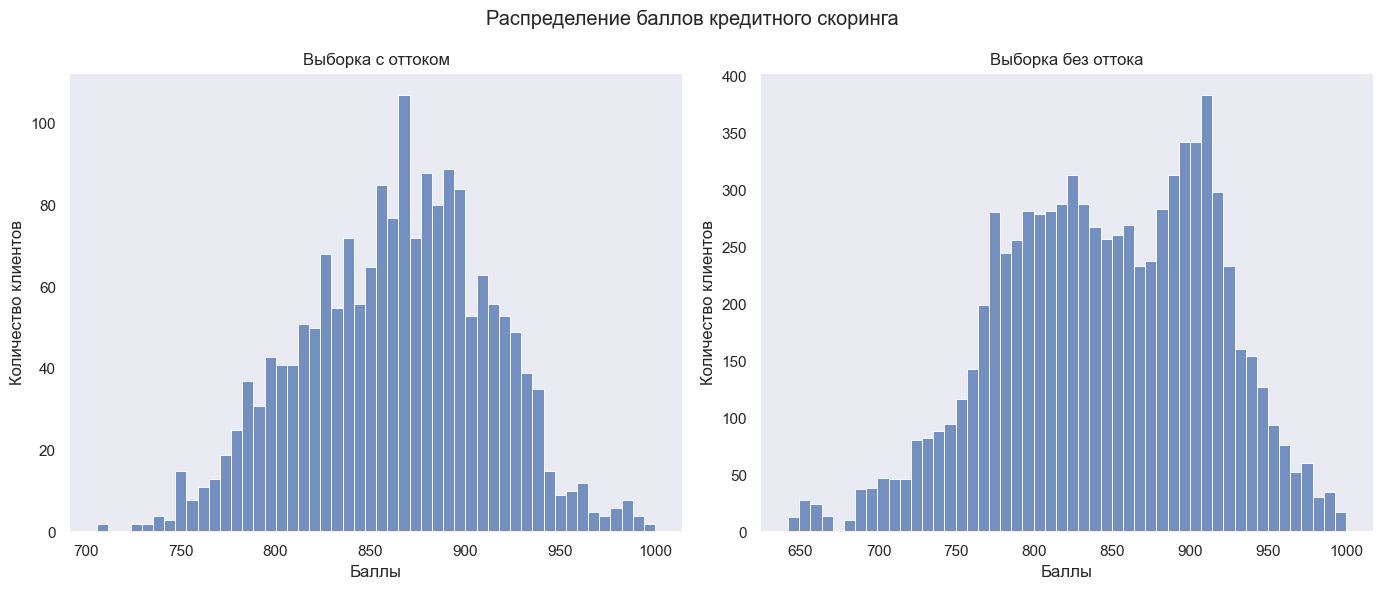

In [182]:
stat_hist(churn_score, no_churn_score, 'Баллы','Распределение баллов кредитного скоринга')

Баллы кредитного скоринга для второй выборки распределены не нормально, но поскольку в выборке большое количество значений это не является препятствием для проведения t-теста благодаря центральной предельной теореме.

Поскольку выборки разбиты по критерию оттока, а в столбце с баллами скоринга пропусков не было, количество значений в обоих выборках будет таким же, как и в предыдущем тесте, поэтому снова используем параметр "equal_var = False".

Выборки пригоды для проведения t-теста.

Нулевая гипотеза: средний балл кредитного скоринга ушедших пользователей равен среднему баллу кредитного скоринга оставшихся пользователей

Альтернативная гипотеза: средние баллы кредитных скорингов между ушедшими и оставшимися пользователями неравны.

In [186]:
# уровень статистической значимости оставим прежним

results = st.ttest_ind(churn_score, no_churn_score, equal_var = False)
print('P-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

P-value: 1.8436753008142297e-37
Отвергаем нулевую гипотезу


Гипотеза о равенстве реднего балла кредитного скоринга для двух групп пользователей отвергается.

### Гипотеза о равенстве среднего возраста

Проверим гипотезу о равенстве среднего возраста между двумя группами клиентов.

In [190]:
# сохраним выборки в переменной, в столбце "age" были значения NaN, поэтому удалим их из выборок функцией .dropna()
churn_age = df[df['churn']==1]['age'].dropna().to_list()
no_churn_age = df[df['churn']==0]['age'].dropna().to_list()

Проверим нормальность распределения двух выборок

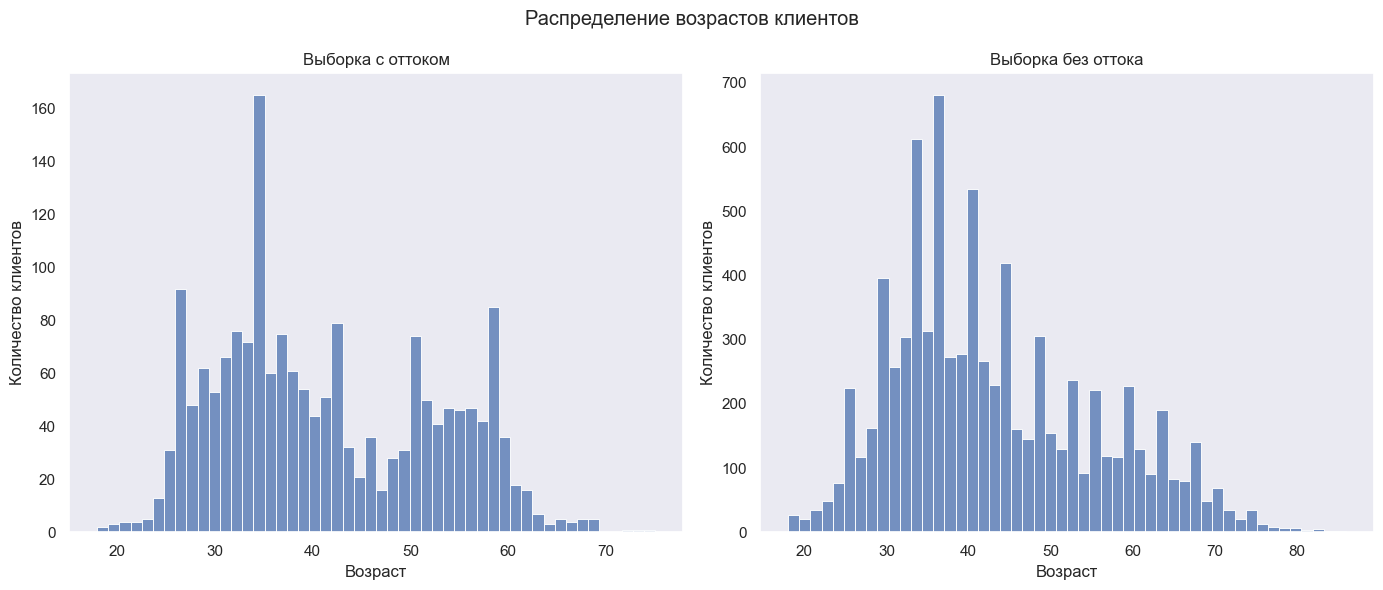

In [192]:
stat_hist(churn_age, no_churn_age, 'Возраст','Распределение возрастов клиентов')

Выбросов нет, но значения выборок не распределены нормально

Посмотрим количество значений в обоих выборках

In [349]:
len_churn_age = len(churn_age)
len_no_churn_age = len(no_churn_age)
print(f'Количество значений в выборке с ушедшими пользователями равно {len_churn_age},\
а в выборке с оставшимися - {len_no_churn_age}')

Количество значений в выборке с ушедшими пользователями равно 1818,а в выборке с оставшимися - 8155


Количество значений в обоих выборках достаточно для проведения теста даже при условии отсутствия нормального распределения данных выборок, однако из-за большой разницы в их размерах нужно будет использовать параметр "equal_var = False"

Переидем к проверке гипотезы

Нулевая гипотеза: средние возрасты у ушедших и оставшихся пользователей равны

Альтернативная гипотеза: средние возрасты у ушедших и оставшихся пользователей не равны

In [199]:
# значение alpha оставим прежним
results = st.ttest_ind(churn_age, no_churn_age, equal_var = False)
print('P-value:',results.pvalue)
if results.pvalue >= alpha:
    print('Не удалось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

P-value: 7.536127357312234e-08
Отвергаем нулевую гипотезу


Гипотеза о равенстве среднего возраста в двух группах клиентов отвергнута

### Гипотеза о равенстве баланса на счете

Проверим гипотезу о равенстве баланса на счете для ушедших и оставшихся клиентов.

In [203]:
churn_balance = df[df['churn']==1]['balance'].dropna()
no_churn_balance = df[df['churn']==0]['balance'].dropna()

Посмотрим на распределения выборок

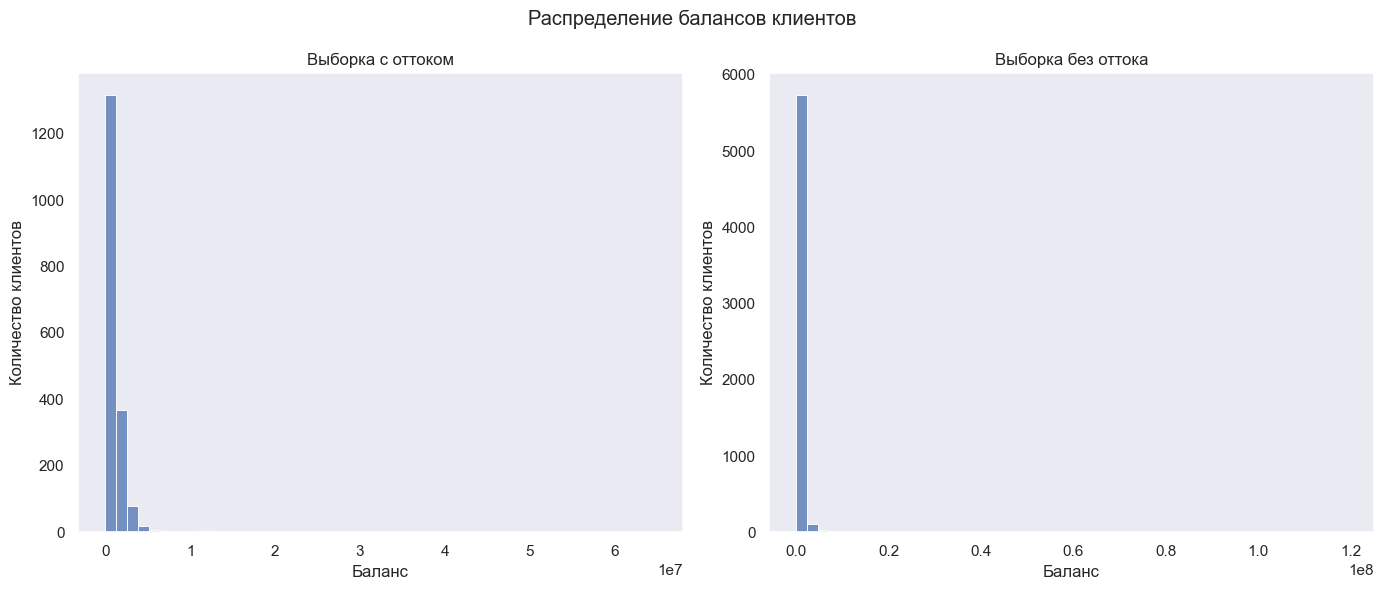

In [205]:
stat_hist(churn_balance, no_churn_balance, 'Баланс','Распределение балансов клиентов')

Очевидно наличие выбросов в данных выборках. Необходимо провести фильтрацию. Определим 95, 97,5 и 99-й перцентили для данных выборок.

In [207]:
print(np.percentile(churn_balance,[95,97.5,99]))
print(np.percentile(no_churn_balance,[95,97.5,99]))

[2995013.282      3780953.271      6278338.92960003]
[1696734.134      2570432.73825    4419748.42409998]


Из-за влияния выбросов на масштаб графиков сложно определить какой из перцентилей будет уместно взять для фильтрации, поэтому рассмотрим графики поближе.

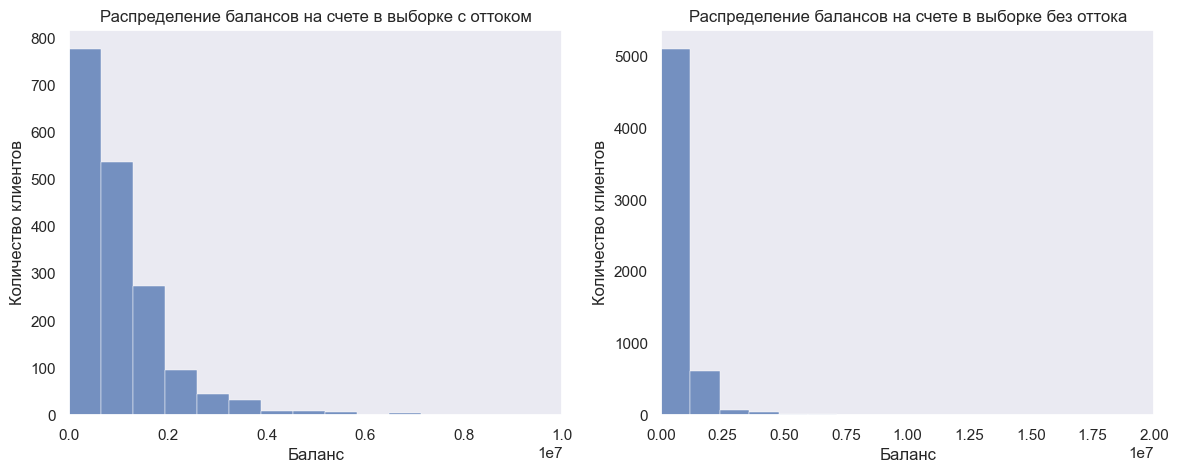

In [209]:
fig, axs = plt.subplots(1,2, figsize = (14,5))
sns.histplot(data = churn_balance,bins = 100, ax = axs[0])
axs[0].set_title('Распределение балансов на счете в выборке с оттоком')
axs[0].set_xlim (0,10000000)
sns.histplot(data = no_churn_balance,bins = 100, ax = axs[1])
axs[1].set_title('Распределение балансов на счете в выборке без оттока')
plt.xlabel('Баланс')
axs[1].set_xlim(0,20000000)
for ax in axs:
    ax.set(xlabel = 'Баланс', ylabel = 'Количество клиентов')
plt.show()

В качестве границы фильтрации возьмем 95-й перцентиль.

In [211]:
churn_balance = churn_balance[churn_balance <= np.percentile(churn_balance, 95)]
no_churn_balance = no_churn_balance[no_churn_balance <= np.percentile(no_churn_balance, 95)]

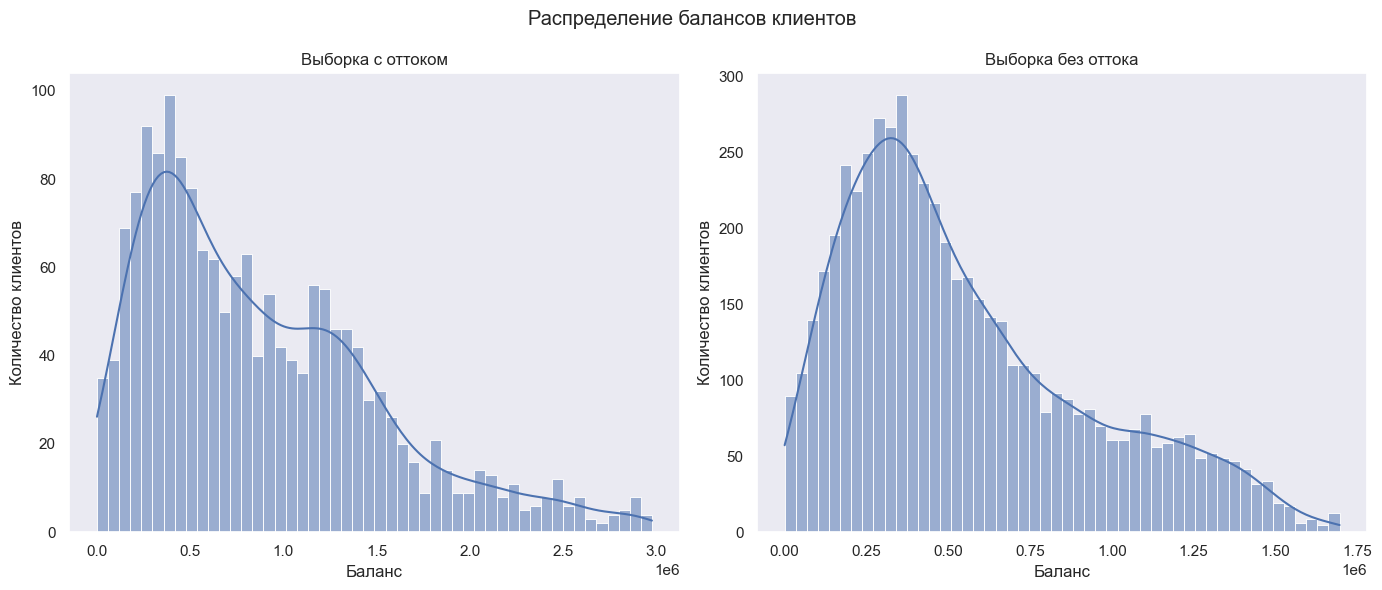

In [212]:
stat_hist(churn_balance, no_churn_balance, 'Баланс','Распределение балансов клиентов',True)

In [213]:
churn_balance_len = len(churn_balance)
no_churn_balance_len = len(no_churn_balance)
print(f'Размер выборки с ушедшими пользователями составляет {churn_balance_len},\
размер выборки с оставшимися - {no_churn_balance_len}')

Размер выборки с ушедшими пользователями составляет 1716, размер выборки с оставшимися - 5603


Значения не распределены нормально, но их количество достаточно, чтобы использовать в тесте (ЦПТ). Размеры выборок снова сильно отличаются, поэтому будем использовать аргумент "equal_var = False".

Приступим к проведению теста. Предположим, что у ушедших пользователей средний баланс на счете выше.

Нулевая гипотеза: средний баланс на счетах ушедших пользователей не выше средних балансов на счетах оставшихся пользователей

Альтернативная гипотеза: средний баланс на счетах ушедших пользователей выше, чем у оставшихся

In [217]:
results = st.ttest_ind(churn_balance, no_churn_balance, equal_var = False, alternative = 'greater')
print('P-value:',results.pvalue)
if results.pvalue >= alpha:
    print('Не удалось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

P-value: 5.442175125943487e-84
Отвергаем нулевую гипотезу


Нулевая гипотеза о равенстве балансов отвергнута. Есть основания предполагать, что баланс на счете ушедших пользователей выше

## Промежуточные итоги

В ходе EDA и проверки статистических гипотез обнаружено, что самые важные признаки, влияющие на отток, это количество баллов собственности, количество продуктов банка, баланс на счете клиента, его половая принадлежность, активность в последнее время, наличие кредитной карты и город.


## Сегментация пользователей

Необходимо провести сегментацию клиентов, удовлетворяющих следующим условиям:
1. Минимум 3 сегмента с долей оттока выше среднего по банку
2. В каждом сегменте минимум 500 клиентов

Важными показателями, влияющими на отток, является высокое количество баллов собственности, высокое количество продуктов банка, баланс клиента, его пол, а также высокая активность, отсутствие кредитной карты и город.

Разделим сегменты по этим признакам.  

Разделим сегменты следующим образом:
* В первый сегмент войдут пользователи с пятью и более баллами собственности, с высоким балансом (более 800 тыс. рублей)
* Во второй - клиенты мужского пола с тремя и более продуктами,
* В третий - активные клиенты без кредитной карты женского пола

Напишем функцию, определяющую сегменты клиентов.

In [226]:
def define_segment(row):
    equity = row['equity']
    card = row['credit_card']
    activity = row['last_activity']
    products = row['products']
    gender = row['gender']
    balance = row['balance']
    city = row['city']
    try:
        if equity >=5 and balance >=800000 and (city == 'Ярославль' or city == 'Ростов'):
            return '1'
        if products >=3 and gender == 'М':
            return '2'
        elif card == 0 and activity==1 and gender == 'Ж':
            return '3' 
    except:
        pass

In [227]:
# применяем написанную функцию
df['segment'] = df.apply(define_segment, axis = 1)

Посмотрим на количество клиентов в каждом сегменте.

In [229]:
df['segment'].value_counts()

segment
3    919
1    848
2    599
Name: count, dtype: int64

В каждом сегменте более 500 клиентов - одно из условий маркетологов удовлетворено.

Визуализируем долю оттока каждого сегмента.

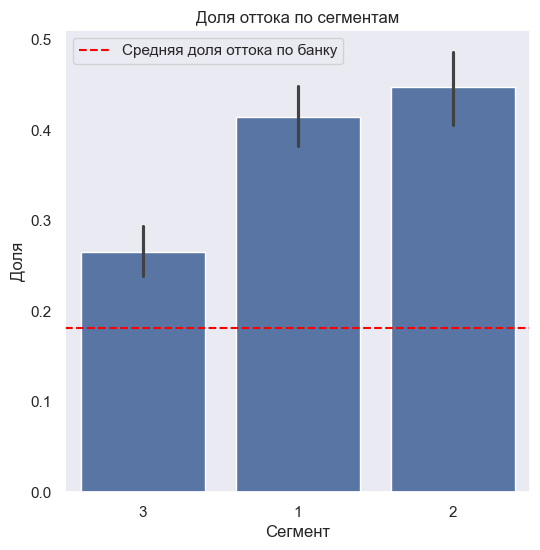

In [232]:
sns.barplot(data = df, x = 'segment', y = 'churn')
plt.axhline(y = df['churn'].mean(), linestyle = '--', color = 'red', label = 'Средняя доля оттока по банку')
plt.legend()
plt.title ('Доля оттока по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Доля')
plt.show()

Мы имеем 3 сегмента с долей оттока выше среднебанковского.

In [345]:
# доля ушедших клиентов в каждом сегменте для вывода
df.groupby('segment')['churn'].mean().round(2)

segment
1    0.41
2    0.45
3    0.27
Name: churn, dtype: float64

Проверим данные после операций.

In [239]:
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9999 non-null   int64  
 1   score          9999 non-null   Int64  
 2   city           9999 non-null   object 
 3   gender         9999 non-null   object 
 4   age            9973 non-null   Int64  
 5   equity         9999 non-null   int64  
 6   balance        7705 non-null   float64
 7   products       9999 non-null   int64  
 8   credit_card    9999 non-null   int64  
 9   last_activity  9999 non-null   int64  
 10  salary         9999 non-null   float64
 11  churn          9999 non-null   int64  
 12  segment        2366 non-null   object 
dtypes: Int64(2), float64(2), int64(6), object(3)
memory usage: 1.1+ MB
None


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,salary,churn,segment
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,3
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,None
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,None
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,1
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,None


Таким образом сегменты выглядят следующим образом:
* Сегмент 1 - 848 клиентов, процент оттока 41,4%, клиенты имеют 5 и более баллов собственности, их баланс свыше 800 тыс. рублей, проживают в городах Ярославль и Ростов.
* Сегмент 2 - 599 клиентов, процент оттока 44,7%, клиенты - мужчины, с 3 и более продуктами банка.
* Сегмент 3 - 919 клиентов, процент оттока 26,5%, в него входят активные в последнее время женщины без кредитной карты.

## Приоритизация сегментов

Учитывая ограниченное число сотрудников отдела маркетинга и отсутствие автоматизированных систем, предлагаю работать с сегментами по следующему приоритету:
1. Сегмент 2
2. Сегмент 1
3. Сегмент 3

Сегмент 2 в приоритете, поскольку имеет самый высокий процент оттока, что делает его более важным, чем остальные два, и имеет наименьшее количество клиентов, что делает работу с ним маркетологам более удобной.

Сегмент 1 более приоритетный, чем сегмент 3 поскольку имеет более высокий процент оттока и меньшее количество клиентов, а клиенты с высокими баллами собственности и высоким балансом приносят банку больше прибыли. 

## Рекоммендации

Учитывая выводы, полученные в ходе работы, можно выделить следующие рекоммендации:
* Сегмент 1 - сделать более выгодные и удобные условия для клиентов с высоким количеством имущества и высоким балансом, проинформировать их об этом.
* Сегмент 2 - упростить взаимодействие с банком у клиентов, пользующихся несколькими продуктами банка, например, оптимизировать личный кабинет для управления продуктами. Провести опрос, пользуются ли клиенты всеми продуктами. Возможно некоторые из них были навязаны и клиенты ими не пользуются, но регулярно получают счета и уведомления. Разобраться почему среди мужчин высокий уровень оттока.
* Сегмент 3 - выяснить почему активные клиенты имеют высокий отток, например, провести опрос удовлетворенности сервисами банка, предложить кредитную карту.

# Презентация

https://drive.google.com/file/d/1FoPg3BFbhW4TgTlNb-y-S9WzsXl_mrkU/view?usp=sharing